In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

true_path = '/content/drive/MyDrive/Fakenewsnet/BuzzFeed_real_news_content.csv'
fake_path = '/content/drive/MyDrive/Fakenewsnet/BuzzFeed_fake_news_content.csv'

true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

true_df['label'] = 1
fake_df['label'] = 0

df = pd.concat([true_df, fake_df])



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,title,label
0,Newsweek Accuses Trump Of Committing A Felony,0
1,I Was RFK’s Speechwriter. Now I’m Voting for T...,1
2,10 Moments That Mattered From Hillary Clinton ...,1
3,Trump’s Latest Campaign Promise May Be His Mos...,0
4,It’s “Trump is HITLER” Month at the Washington...,1
...,...,...
177,In Defense of ‘He Said/She Said’ Journalism,1
178,Inmate Dead From Alleged Mistreatment In Jail ...,1
179,Liberals Are Furious When Reality Star Brody J...,1
180,Donald Trump's rise puts Ted Cruz in a bind,1


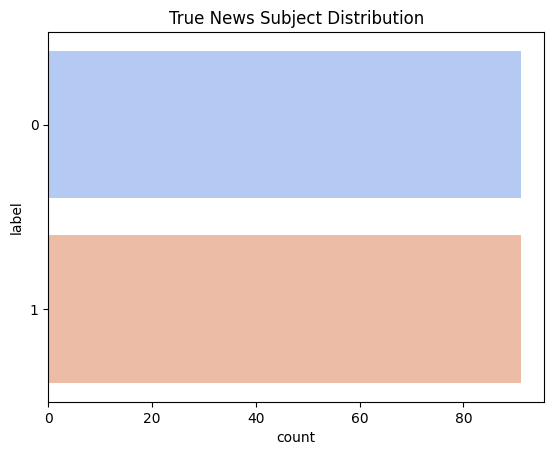

In [2]:
from sklearn.utils import shuffle

df = df[['title','label']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="label", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   182 non-null    object
 1   label   182 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [4]:
df.drop_duplicates(subset=['title'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   178 non-null    object
 1   label   178 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['title'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [7]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
print('Median length of the titles:', np.median(titles_len))

Number of titles: 178
Max length of the titles: 16
Mean length of the titles: 7.820224719101123
Median length of the titles: 8.0


In [8]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(df['title'])

sequences = tokenizer.texts_to_sequences(df['title'])
padded_df = pad_sequences(sequences,maxlen = max_len, padding = 'pre', truncating = 'post')


# **LSTM**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.regularizers import l2
## Creating model Using LSTM
optimizer = Adam(lr=0.01)
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_len))
model.add(Dropout(0.3))
model.add(Conv1D(32,3,activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(32,3,activation='relu'))
model.add(MaxPool1D())
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])



/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
from sklearn.model_selection import train_test_split
z =np.array(padded_df)
y =np.array(df['label'])
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)


Epoch 1/10
2/2 [==============================] - 13s 1s/step - loss: 0.6944 - accuracy: 0.5242 - val_loss: 0.6810 - val_accuracy: 0.6111
Epoch 2/10
2/2 [==============================] - 0s 37ms/step - loss: 0.6805 - accuracy: 0.5887 - val_loss: 0.6340 - val_accuracy: 0.7778
Epoch 3/10
2/2 [==============================] - 0s 35ms/step - loss: 0.6240 - accuracy: 0.7500 - val_loss: 0.5563 - val_accuracy: 0.8333
Epoch 4/10
2/2 [==============================] - 0s 54ms/step - loss: 0.4599 - accuracy: 0.8629 - val_loss: 0.5252 - val_accuracy: 0.7222
Epoch 5/10
2/2 [==============================] - 0s 37ms/step - loss: 0.2394 - accuracy: 0.9113 - val_loss: 0.6312 - val_accuracy: 0.7778
Epoch 6/10
2/2 [==============================] - 0s 36ms/step - loss: 0.0971 - accuracy: 0.9677 - val_loss: 1.0759 - val_accuracy: 0.8333
Epoch 7/10
2/2 [==============================] - 0s 56ms/step - loss: 0.0378 - accuracy: 0.9919 - val_loss: 1.1198 - val_accuracy: 0.7222
Epoch 8/10
2/2 [============

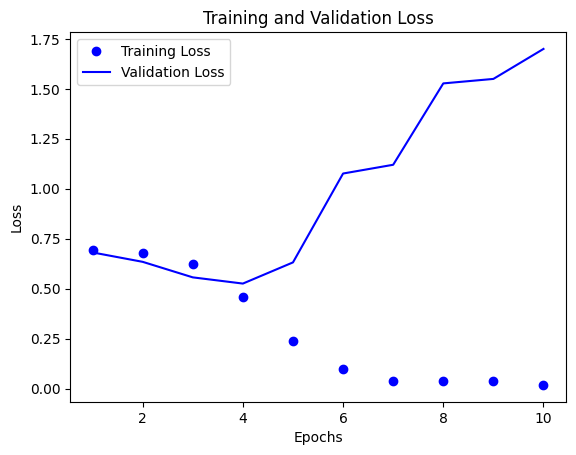

In [11]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 10)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 1s 39ms/step
CNN-BiLSTM Model Accuracy :  0.5555555555555556
Precision :  0.5238095238095238
Recall :  0.6470588235294118
F1 :  0.5789473684210527
G-mean: 0.5536258194734203
Training time:  14.031723976135254
Inference time:  1.0332915782928467
              precision    recall  f1-score   support

           0       0.60      0.47      0.53        19
           1       0.52      0.65      0.58        17

    accuracy                           0.56        36
   macro avg       0.56      0.56      0.55        36
weighted avg       0.56      0.56      0.55        36



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


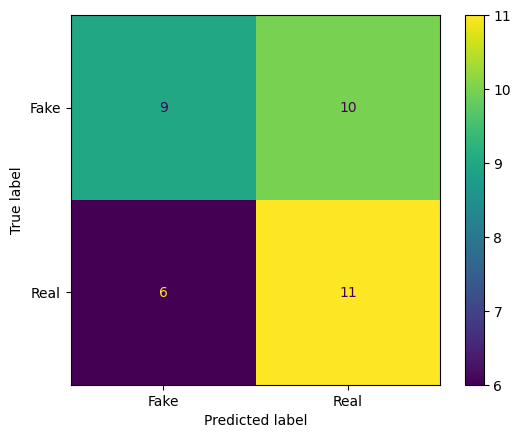

In [12]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("CNN-BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()